In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

c:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_directory = 'data/'
file_names = [
    'Batch_corrected_Expression_Public_24Q4_subsetted.csv',
    'Damaging_Mutations_subsetted.csv', 
    'Harmonized_RPPA_CCLE_subsetted.csv',
    'Hotspot_Mutations_subsetted.csv', 
    'IC50_AUC_merged.csv', 
    'Metabolomics_subsetted.csv',
    'miRNA_Expression_subsetted.csv',
    'Omics_Absolute_CN_Gene_Public_24Q4_subsetted.csv'
    ]

In [3]:
# select the omics data to train
data_file_name = f'{data_directory}{file_names[1]}'
omics_data_name = "Damaging_Mutations"

# Data Load

### Load SMILES data and tokenize

In [4]:
smiles = pd.read_csv("./data/drugID_name_pubchem_smiles.csv")

In [5]:
# load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenize
tokens = tokenizer(smiles["smiles"].tolist(), padding=True, truncation=True, return_tensors="pt")

# embedded tokenized SMILES
with torch.no_grad():
    outputs = model(**tokens)

# CLS token (for now, we will only use CLS token)
cls_embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, hidden_dim)

cls_embeddings_np = cls_embeddings.cpu().numpy()

smiles["CLS"] = list(cls_embeddings_np)

print(smiles.head())

   drugID          drugName  pubchemID  \
0    1003  (+)-CAMPTOTHECIN      24360   
1    1004            VELBAN    5388983   
2    1006        CYTARABINE       6253   
3    1007         DOCETAXEL     148124   
4    1010         GEFITINIB     123631   

                                              smiles  \
0  CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...   
1  CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...   
2                 C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O   
3  CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...   
4  COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...   

                                                 CLS  
0  [-0.050628018, 0.88478583, -1.6744763, 1.31876...  
1  [1.524386, 0.27689624, -0.80197245, -0.9936369...  
2  [-0.39218664, 0.06059071, -0.88434273, 0.23520...  
3  [0.5116886, 0.7362517, -1.3978803, -0.69533825...  
4  [-0.73378813, 0.74604344, -1.19528, 1.1188792,...  


### Load IC50 and AUC data

In [6]:
IC50_AUC = pd.read_csv("./data/IC50_AUC_merged.csv")
IC50_AUC = IC50_AUC.rename(columns={"Unnamed: 0": "CellLineID"})

In [7]:
melted = IC50_AUC.melt(
    id_vars=["CellLineID"],  # fixed column
    var_name="metric_drug",  # column names that will be one single column
    value_name="value"       
)
melted.head()

,CellLineID,metric_drug,value
0,ACH-000001,Drug sensitivity AUC (Sanger GDSC2) (+)-CAMPTO...,0.967187
1,ACH-000002,Drug sensitivity AUC (Sanger GDSC2) (+)-CAMPTO...,0.711866
2,ACH-000004,Drug sensitivity AUC (Sanger GDSC2) (+)-CAMPTO...,0.742350
3,ACH-000006,Drug sensitivity AUC (Sanger GDSC2) (+)-CAMPTO...,0.752250
4,ACH-000007,Drug sensitivity AUC (Sanger GDSC2) (+)-CAMPTO...,0.845466


In [8]:
# ex: "Drug sensitivity AUC (Sanger GDSC2) CAMPTOTHECIN (GDSC2:1003)" -> (AUC), (CAMPTOTHECIN), (1003)
pattern = r"(AUC|IC50).*?\((Sanger GDSC2)\)\s+(.*?)\s+\(GDSC2:(\d+)\)"

# (AUC|IC50) -> 1) AUC or IC50
# (.*?)      -> 3) Drug name (minimum match)
# (\d+)      -> 4) drug number from GDSC2:XXXX


In [9]:
melted[["Metric", "_sanger", "DrugName", "DrugNumber"]] = melted["metric_drug"].str.extract(pattern)
new_melted = melted[['CellLineID', 'value', 'Metric','DrugNumber']]
new_melted.head()

,CellLineID,value,Metric,DrugNumber
0,ACH-000001,0.967187,AUC,1003
1,ACH-000002,0.711866,AUC,1003
2,ACH-000004,0.742350,AUC,1003
3,ACH-000006,0.752250,AUC,1003
4,ACH-000007,0.845466,AUC,1003


In [10]:
final_IC50_AUC = (
    new_melted
    .pivot(index=["CellLineID", "DrugNumber"], 
           columns="Metric", 
           values="value")
    #.reset_index()
)


In [11]:
final_IC50_AUC = final_IC50_AUC.dropna(subset=['AUC', 'IC50'], how='all') # drop the row that AUC and IC50 are both NAN
final_IC50_AUC.columns.name = None
final_IC50_AUC

AUC     IC50
CellLineID DrugNumber                   
ACH-000001 1003        0.967187      NaN
           1004        0.666062      NaN
           1005        0.977907      NaN
           1007        0.922989      NaN
           1010        0.957586      NaN
...                         ...      ...
ACH-002317 2096        0.946713      NaN
           2107        0.926422      NaN
           2109        0.916274  3.25832
           2110        0.906540      NaN
           2170        0.996681      NaN

[98430 rows x 2 columns]

In [12]:
final_IC50_AUC.to_csv("temp.csv") # had to save and reload to make CellLIneID and DrugNumber to column

In [13]:
IC50_AUC_final = pd.read_csv("temp.csv")

In [14]:
# merge IC50, AUC, and SMILES (CLS)
df_merged = pd.merge(IC50_AUC_final, smiles, left_on='DrugNumber', right_on='drugID', how='inner')

In [15]:
ic50_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'IC50']].copy()
ic50_data['AUC'] = None # each row will have either AUC or IC50 value. 
ic50_data = ic50_data.rename(columns={'IC50': 'IC50'})

auc_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'AUC']].copy()
auc_data['IC50'] = None 
auc_data = auc_data.rename(columns={'AUC': 'AUC'})

final_df = pd.concat([ic50_data, auc_data])
final_df = final_df.sort_values(by=['CellLineID', 'DrugNumber']).reset_index(drop=True)
final_df = final_df.dropna(subset=['AUC', 'IC50'], how='all').reset_index(drop=True)

final_df

C:\Users\user\AppData\Local\Temp\ipykernel_26492\1315804172.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([ic50_data, auc_data])


,CellLineID,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000001,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",NaN,0.967187
1,ACH-000001,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.524386, 0.27689624, -0.80197245, -0.9936369...",NaN,0.666062
2,ACH-000001,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.734997, 0.018372245, -0.4958414, 0.2950676,...",NaN,0.977907
3,ACH-000001,1007,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,"[0.5116886, 0.7362517, -1.3978803, -0.69533825...",NaN,0.922989
4,ACH-000001,1010,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...,"[-0.73378813, 0.74604344, -1.19528, 1.1188792,...",NaN,0.957586
...,...,...,...,...,...,...
117641,ACH-002317,2107,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...,"[0.32438743, -0.20456038, -0.47426504, 0.15297...",NaN,0.926422
117642,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",3.25832,NaN
117643,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",NaN,0.916274
117644,ACH-002317,2110,C1CC(C1)NC2=NC=CC(=C2)C(=O)NCC(CN3CCC4=CC=CC=C...,"[-0.07692237, -0.47833273, -0.6763192, -0.5061...",NaN,0.906540


### Load omics data

In [16]:
omics = pd.read_csv(data_file_name)
omics = omics.rename(columns={omics.columns[0]: "CellLineID"})
omics

,CellLineID,A1BG,A1CF,A2M,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,ACH-000001,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,ACH-000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACH-000004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACH-000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACH-000006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,ACH-003473,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1925,ACH-003474,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926,ACH-003475,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1927,ACH-003476,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.feature_selection import VarianceThreshold

omics_ = omics.drop(columns="CellLineID")
# VarianceThreshold 설정 (0에 가까운 값이 대부분인 feature 제거)
selector = VarianceThreshold(threshold=0.01) # 분산 0.01 이하의 feature 제거
omics_reduced = selector.fit_transform(omics_)

# 제거되지 않은 feature의 인덱스 가져오기
selected_columns = omics_.columns[selector.get_support()]

# DataFrame으로 변환 (컬럼 유지)
X_reduced_df = pd.DataFrame(omics_reduced, columns=selected_columns)
X_reduced_df = pd.concat([omics["CellLineID"], X_reduced_df], axis=1)

print(X_reduced_df.shape)
X_reduced_df

(1929, 1255)


,CellLineID,A2ML1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA4,ABCA5,ABCA6,ABCA8,...,ZNF711,ZNF729,ZNF750,ZNF804B,ZNF831,ZNF90,ZNF99,ZRANB3,ZSWIM6,ZZEF1
0,ACH-000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACH-000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACH-000004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACH-000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACH-000006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,ACH-003473,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1925,ACH-003474,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926,ACH-003475,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1927,ACH-003476,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_merged = pd.merge(final_df, X_reduced_df, left_on='CellLineID', right_on='CellLineID', how='inner')
df_merged

,CellLineID,DrugNumber,smiles,CLS,IC50,AUC,A2ML1,ABCA10,ABCA12,ABCA13,...,ZNF711,ZNF729,ZNF750,ZNF804B,ZNF831,ZNF90,ZNF99,ZRANB3,ZSWIM6,ZZEF1
0,ACH-000001,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",NaN,0.967187,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACH-000001,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.524386, 0.27689624, -0.80197245, -0.9936369...",NaN,0.666062,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACH-000001,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.734997, 0.018372245, -0.4958414, 0.2950676,...",NaN,0.977907,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACH-000001,1007,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,"[0.5116886, 0.7362517, -1.3978803, -0.69533825...",NaN,0.922989,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACH-000001,1010,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...,"[-0.73378813, 0.74604344, -1.19528, 1.1188792,...",NaN,0.957586,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115778,ACH-002317,2107,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...,"[0.32438743, -0.20456038, -0.47426504, 0.15297...",NaN,0.926422,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115779,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",3.25832,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115780,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",NaN,0.916274,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115781,ACH-002317,2110,C1CC(C1)NC2=NC=CC(=C2)C(=O)NCC(CN3CCC4=CC=CC=C...,"[-0.07692237, -0.47833273, -0.6763192, -0.5061...",NaN,0.906540,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# split to feature and target
X = df_merged.drop(columns=["CellLineID", "DrugNumber",	"smiles", "AUC", "IC50"])
y = df_merged[["AUC", "IC50"]]
X.head()

,CLS,A2ML1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA4,ABCA5,ABCA6,ABCA8,...,ZNF711,ZNF729,ZNF750,ZNF804B,ZNF831,ZNF90,ZNF99,ZRANB3,ZSWIM6,ZZEF1
0,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[1.524386, 0.27689624, -0.80197245, -0.9936369...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[0.734997, 0.018372245, -0.4958414, 0.2950676,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[0.5116886, 0.7362517, -1.3978803, -0.69533825...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[-0.73378813, 0.74604344, -1.19528, 1.1188792,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
y.head()

,AUC,IC50
0,0.967187,NaN
1,0.666062,NaN
2,0.977907,NaN
3,0.922989,NaN
4,0.957586,NaN


### Data Preprocessing

In [ ]:
cls_array = X["CLS"]
omics_array = X.drop(columns="CLS").to_numpy(dtype=np.float32)
y_array = y.to_numpy(dtype=np.float32)

# Scaling
# Omics -> Z-score normalization
#scaler_omics = StandardScaler()
#omics_array = scaler_omics.fit_transform(omics_array)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
omics_array = scaler.fit_transform(omics_array)  # CellLineID 제외한 나머지 데이터 스케일링

# AUC -> log transformation
epsilon = 1e-10  # prevent zero division
y_array[:, 0] = np.log10(np.where(y_array[:, 0] == 0, epsilon, y_array[:, 0]))
# Maybe MinMax Scaling?
#scaler_AUC = MinMaxScaler()
#y_array[:, 0] = scaler_AUC.fit_transform(y_array[:, 0].reshape(-1, 1)).flatten()

# IC50 -> MinMax Scaling
scaler_IC50 = MinMaxScaler()
y_array[:, 1] = scaler_IC50.fit_transform(y_array[:, 1].reshape(-1, 1)).flatten()

In [25]:
cls_tensor = torch.tensor(cls_array)
omics_tensor = torch.tensor(omics_array)
target_tensor = torch.tensor(y_array)

# train, validation, test : 80, 10, 10
train_smiles, test_smiles, train_omics, test_omics, train_y, test_y = train_test_split(
    cls_tensor, omics_tensor, target_tensor, test_size=0.1, random_state=42
)

train_smiles, val_smiles, train_omics, val_omics, train_y, val_y = train_test_split(
    train_smiles, train_omics, train_y, test_size=0.1, random_state=42
)

print("train_smiles shape =", train_smiles.shape)
print("val_smiles shape =", val_smiles.shape)
print("test_smiles shape =", test_smiles.shape)
print("train_omics shape =", train_omics.shape)
print("val_omics shape =", val_omics.shape)
print("test_omics shape =", test_omics.shape)
print("train_y shape =", train_y.shape)
print("val_y shape =", val_y.shape)
print("test_y shape =", test_y.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_26492\2366491811.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  cls_tensor = torch.tensor(cls_array)


train_smiles shape = torch.Size([93783, 768])
val_smiles shape = torch.Size([10421, 768])
test_smiles shape = torch.Size([11579, 768])
train_omics shape = torch.Size([93783, 1254])
val_omics shape = torch.Size([10421, 1254])
test_omics shape = torch.Size([11579, 1254])
train_y shape = torch.Size([93783, 2])
val_y shape = torch.Size([10421, 2])
test_y shape = torch.Size([11579, 2])


In [26]:
train_dataset = TensorDataset(train_smiles, train_omics, train_y)
val_dataset = TensorDataset(val_smiles, val_omics, val_y)
test_dataset = TensorDataset(test_smiles, test_omics, test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Train Dataset: 93783 samples
Validation Dataset: 10421 samples
Test Dataset: 11579 samples


# Model Design

- training data: omics feature, AUC, IC50, drug structure(SMILES). Each sample will have either AUC or IC50 value.
- test data:
    - input: omics feature and drug structure
    - output: predicted AUC and IC50 value according

While calculating the loss, it will not consider either IC50/AUC prediction value if it has Nan value. => A single model will learn algorithm for each AUC and IC50

Things to think about: Our logic was, because transformer is good at learning sequence data, and drug structure is sequence so we are using transformer. however, our model now is using builtin model for tokenizing SMILES, and it already does "encoding" process instead of our transformer. Even our transformer will encode omics data, is it still reasonable to use transformer?

-> new point(need to edit introduction): with TF, we will capture interaction inside each omics data

Plus, since we are treating SMILES and omics separately in transformer (each are using different encoder), transformer couldn't learn the interaction between them. Thus we will use cross-attention between them to learn relationship

In [27]:
class MultiTaskRegressionTransformer(nn.Module):
    def __init__(self, chemberta_dim, d_model, nhead, num_layers, num_omics):
        super(MultiTaskRegressionTransformer, self).__init__()
        
        # CLS expression for SMILES is already embedded seperately by ChemBERTa
        self.chemberta_dim = chemberta_dim

        # Omics -> Transformer Encoder
        self.omics_fc = nn.Linear(num_omics, d_model)
        self.omics_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.omics_transformer = nn.TransformerEncoder(self.omics_encoder_layer, num_layers=num_layers)
        
        # cls -> embed to d_model dimension
        self.cls_proj = nn.Linear(self.chemberta_dim, d_model)
        
        # Cross-Attention (omics and drug data were embedded by different encoder, so we need to train their relationship additionally)
        # SMILES -> omics
        self.cross_attn_smiles = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        # Omics -> SMILES
        self.cross_attn_omics = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        
        # fuse two cross-attn information
        self.fusion_mlp = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        
        # prediction heads
        self.ic50_head = nn.Linear(d_model, 1)
        self.auc_head = nn.Linear(d_model, 1)
        
    def forward(self, cls_data, omics_data):
        """
        cls_data: SMILES CLS expression (batch_size, chemberta_dim)
        omics_data: (batch_size, num_omics) 
        """
        
        # Omics: fc → Transformer Encoder
        omics_repr = self.omics_fc(omics_data) # (batch_size, d_model)
        omics_repr = omics_repr.unsqueeze(1) # (batch_size, 1, d_model)
        omics_repr = self.omics_transformer(omics_repr) # (batch_size, 1, d_model)
        omics_repr = omics_repr.squeeze(1) # (batch_size, d_model)
        
        # project SMILES to d_model
        smiles_proj = self.cls_proj(cls_data) # (batch_size, d_model)
        
        # (batch_first=True → [batch, seq_len, d_model])
        smiles_seq = smiles_proj.unsqueeze(1) # (batch_size, 1, d_model)
        omics_seq = omics_repr.unsqueeze(1) # (batch_size, 1, d_model)
        
        # Cross-Attention
        # 1. SMILES -> omics: query=smiles, key/value=omics
        attn_smiles, _ = self.cross_attn_smiles(query=smiles_seq, key=omics_seq, value=omics_seq)
        # 2. Omics -> SMILES: query=omics, key/value=smiles
        attn_omics, _ = self.cross_attn_omics(query=omics_seq, key=smiles_seq, value=smiles_seq)
        
        # Residual connection (add attention result to original data) -> reserve original data
        smiles_updated = smiles_proj + attn_smiles.squeeze(1) # (batch_size, d_model)
        omics_updated = omics_repr + attn_omics.squeeze(1) # (batch_size, d_model)
        
        # Send to MLP
        fused = torch.cat([smiles_updated, omics_updated], dim=1) # (batch_size, 2*d_model)
        fused = self.fusion_mlp(fused) # (batch_size, d_model)
        
        # Final prediction
        ic50_pred = self.ic50_head(fused) # (batch_size, 1)
        auc_pred = self.auc_head(fused) # (batch_size, 1)
        
        return ic50_pred, auc_pred


In [28]:
# hyperparamter
d_model = 512 # can be adjust, should be divisible by nhead
nhead = 8 # can be adjust
num_layers = 4 # can be adjust
num_omics = train_omics.shape[1]
cls_dim = train_smiles.shape[1]

In [29]:
# model setting
model = MultiTaskRegressionTransformer(cls_dim, d_model, nhead, num_layers, num_omics)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [30]:
num_epochs = 1000
patience = 100 # for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None

# training loop
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0
    for batch in train_loader:
        smiles_list, omics_data, targets = batch
        ic50_targets, auc_targets = targets[:, 0], targets[:, 1]
        
        smiles_list = smiles_list.to(device)
        omics_data = omics_data.to(device)
        ic50_targets = ic50_targets.to(device)
        auc_targets = auc_targets.to(device)
        
        optimizer.zero_grad()
        ic50_pred, auc_pred = model(smiles_list, omics_data)

        # weight for auc loss and IC50 loss
        w_ic50 = 2.0 # AUC is trained easier than IC50, so set IC50 weight larger (need further experiment)
        w_auc = 1.0   
        loss = 0.0
        
        # compute loss for valid target (which is not NAN)
        ic50_mask = ~torch.isnan(ic50_targets)
        auc_mask = ~torch.isnan(auc_targets)
        
        if ic50_mask.sum() > 0:
            loss_ic50 = criterion(ic50_pred[ic50_mask], ic50_targets[ic50_mask].unsqueeze(1))
            loss += w_ic50 * loss_ic50
        if auc_mask.sum() > 0:
            loss_auc = criterion(auc_pred[auc_mask], auc_targets[auc_mask].unsqueeze(1))
            loss += w_auc * loss_auc
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            smiles_list, omics_data, targets = batch
            ic50_targets, auc_targets = targets[:, 0], targets[:, 1]
            
            smiles_list = smiles_list.to(device)
            omics_data = omics_data.to(device)
            ic50_targets = ic50_targets.to(device)
            auc_targets = auc_targets.to(device)
            
            ic50_pred, auc_pred = model(smiles_list, omics_data)
            
            loss = 0.0
            ic50_mask = ~torch.isnan(ic50_targets)
            auc_mask = ~torch.isnan(auc_targets)
            
            if ic50_mask.sum() > 0:
                loss_ic50 = criterion(ic50_pred[ic50_mask], ic50_targets[ic50_mask].unsqueeze(1))
                loss += loss_ic50
            if auc_mask.sum() > 0:
                loss_auc = criterion(auc_pred[auc_mask], auc_targets[auc_mask].unsqueeze(1))
                loss += loss_auc
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")
    
    # best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"./best_models/best_model_{omics_data_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Epoch 1/1000 - Train Loss: 0.0240 - Validation Loss: 0.0106
Validation loss improved. Best model updated.
Epoch 2/1000 - Train Loss: 0.0169 - Validation Loss: 0.0092
Validation loss improved. Best model updated.
Epoch 3/1000 - Train Loss: 0.0154 - Validation Loss: 0.0128
No improvement for 1 epoch(s).
Epoch 4/1000 - Train Loss: 0.0151 - Validation Loss: 0.0090
Validation loss improved. Best model updated.
Epoch 5/1000 - Train Loss: 0.0144 - Validation Loss: 0.0130
No improvement for 1 epoch(s).
Epoch 6/1000 - Train Loss: 0.0147 - Validation Loss: 0.0090
No improvement for 2 epoch(s).
Epoch 7/1000 - Train Loss: 0.0136 - Validation Loss: 0.0082
Validation loss improved. Best model updated.
Epoch 8/1000 - Train Loss: 0.0135 - Validation Loss: 0.0082
No improvement for 1 epoch(s).
Epoch 9/1000 - Train Loss: 0.0131 - Validation Loss: 0.0087
No improvement for 2 epoch(s).
Epoch 10/1000 - Train Loss: 0.0125 - Validation Loss: 0.0083
No improvement for 3 epoch(s).
Epoch 11/1000 - Train Loss: 0


 **Test Results:**
IC50_MSE: 0.0035
IC50_MAE: 0.0323
IC50_R2: 0.5760
AUC_MSE: 0.0050
AUC_MAE: 0.0519
AUC_R2: 0.8633


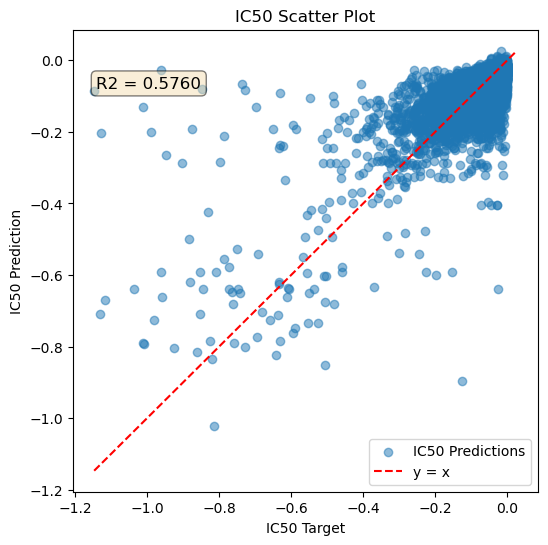

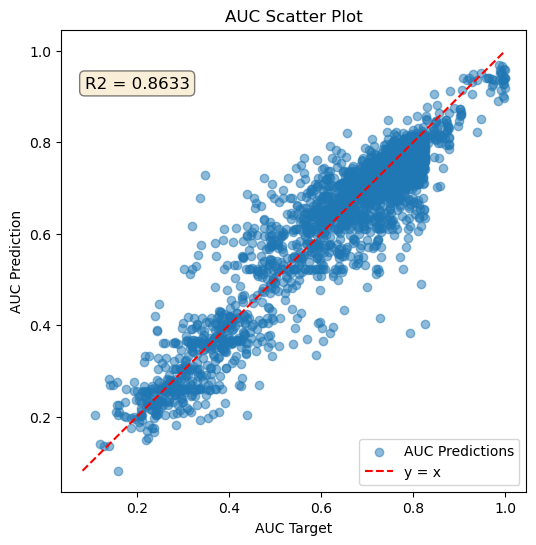

In [ ]:
# utility function for testing
def test_model(model, test_loader, device):
    model.eval()
    ic50_preds, ic50_targets = [], []
    auc_preds, auc_targets = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            smiles_list, omics_data, targets = batch
            ic50_true, auc_true = targets[:, 0], targets[:, 1]

            smiles_list = smiles_list.to(device)
            omics_data = omics_data.to(device)
            ic50_true = ic50_true.to(device)
            auc_true = auc_true.to(device)

            ic50_pred, auc_pred = model(smiles_list, omics_data)

            ic50_mask = ~torch.isnan(ic50_true)
            auc_mask = ~torch.isnan(auc_true)

            if ic50_mask.sum() > 0:
                ic50_preds.append(ic50_pred[ic50_mask].cpu().numpy())
                ic50_targets.append(ic50_true[ic50_mask].cpu().numpy())
            if auc_mask.sum() > 0:
                auc_preds.append(auc_pred[auc_mask].cpu().numpy())
                auc_targets.append(auc_true[auc_mask].cpu().numpy())

        # list -> numpy
        ic50_preds = np.concatenate(ic50_preds) if ic50_preds else np.array([])
        ic50_targets = np.concatenate(ic50_targets) if ic50_targets else np.array([])
        auc_preds = np.concatenate(auc_preds) if auc_preds else np.array([])
        auc_targets = np.concatenate(auc_targets) if auc_targets else np.array([])

        # evaluation
        metrics = {}
        if len(ic50_preds) > 0:
            metrics["IC50_MSE"] = mean_squared_error(ic50_targets, ic50_preds)
            metrics["IC50_MAE"] = mean_absolute_error(ic50_targets, ic50_preds)
            metrics["IC50_R2"] = r2_score(ic50_targets, ic50_preds)
        if len(auc_preds) > 0:
            metrics["AUC_MSE"] = mean_squared_error(auc_targets, auc_preds)
            metrics["AUC_MAE"] = mean_absolute_error(auc_targets, auc_preds)
            metrics["AUC_R2"] = r2_score(auc_targets, auc_preds)

        print("\n **Test Results:**")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
        
        # IC50 Scatter Plot
        if len(ic50_preds) > 0:
            plt.figure(figsize=(6,6))
            plt.scatter(ic50_targets, ic50_preds, alpha=0.5, label="IC50 Predictions")
            # y = x 
            min_val = min(np.min(ic50_targets), np.min(ic50_preds))
            max_val = max(np.max(ic50_targets), np.max(ic50_preds))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
            plt.xlabel("IC50 Target")
            plt.ylabel("IC50 Prediction")
            plt.title("IC50 Scatter Plot")
            # R2
            plt.text(0.05, 0.90, f"R2 = {metrics['IC50_R2']:.4f}", transform=plt.gca().transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
            plt.legend(loc="lower right")
            plt.show()
        
        # AUC Scatter Plot
        if len(auc_preds) > 0:
            plt.figure(figsize=(6,6))
            plt.scatter(auc_targets, auc_preds, alpha=0.5, label="AUC Predictions")
            min_val = min(np.min(auc_targets), np.min(auc_preds))
            max_val = max(np.max(auc_targets), np.max(auc_preds))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
            plt.xlabel("AUC Target")
            plt.ylabel("AUC Prediction")
            plt.title("AUC Scatter Plot")
            plt.text(0.05, 0.90, f"R2 = {metrics['AUC_R2']:.4f}", transform=plt.gca().transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
            plt.legend(loc="lower right")
            plt.show()
        
        return metrics

# load the best model
model.load_state_dict(torch.load(best_model_filename, map_location=device))

# test
test_metrics = test_model(model, test_loader, device)
